In [1]:
NOTE = 'LightGBMベクトルは除外しPitcherIDでGroupKFold'
notebook_name = '083'
CV = 'GroupK-Fold(pitcherID)'
group_col = 'pitcherID'

In [2]:
import json
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

083_submission.csv 083


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
groups = train[group_col]

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])
# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(12, 384, 107)

In [7]:
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [8]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [9]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [10]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [11]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [12]:
with open(os.path.join('001_EDA', f'group_kfold_{group_col}.json'), 'r') as f:
    fold = json.load(f)
fold

{'0': [120,
  478,
  504,
  607,
  587,
  107,
  136,
  447,
  363,
  2,
  618,
  593,
  616,
  597,
  407,
  48,
  58,
  4,
  394,
  49],
 '1': [311,
  305,
  269,
  143,
  224,
  182,
  267,
  55,
  156,
  550,
  371,
  336,
  575,
  158,
  400,
  211,
  647,
  222,
  493,
  528],
 '2': [130,
  651,
  298,
  448,
  387,
  405,
  634,
  438,
  102,
  245,
  507,
  190,
  147,
  520,
  169,
  210,
  409,
  595,
  494,
  630],
 '3': [247,
  128,
  282,
  185,
  657,
  288,
  459,
  45,
  419,
  16,
  434,
  579,
  596,
  435,
  81,
  334,
  181,
  6,
  467,
  635],
 '4': [348,
  373,
  191,
  101,
  116,
  59,
  383,
  517,
  506,
  350,
  376,
  460,
  35,
  97,
  650,
  119,
  662,
  10,
  359],
 '5': [542,
  241,
  155,
  218,
  196,
  82,
  532,
  524,
  31,
  294,
  110,
  578,
  137,
  476,
  358,
  552,
  262,
  553],
 '6': [483,
  519,
  377,
  395,
  481,
  -1,
  146,
  563,
  29,
  25,
  539,
  114,
  522,
  501,
  474,
  440,
  351,
  275],
 '7': [629,
  365,
  640,
  623,
  

In [13]:
%%time
# splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
# for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
for str_i, ids in fold.items():
    i = int(str_i)
    mask = groups.isin(ids)  # training/validation = False/True
    train_idx, id_train, X_train, y_train, valid_idx, id_valid, X_valid, y_valid = (
        train[~mask].index,
        train[~mask].id,
        train[~mask][features],
        train[~mask].y,
        train[mask].index,
        train[mask].id,
        train[mask][features],
        train[mask].y,
    )
    # feature transformation
    ## categorical features
    """
    X_train_categorical = X_train.copy()[categorical_features]
    X_valid_categorical = X_valid.copy()[categorical_features]
    X_test_categorical = test.copy()[categorical_features]
    """
    ## descrete features
    """
    discrete_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    ).fit(X_train.copy()[discrete_features])
    X_train_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_train.copy()[discrete_features]),
        columns=discrete_features,
        index=train_idx
    )
    X_valid_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_valid.copy()[discrete_features]),
        columns=discrete_features,
        index=valid_idx
    )
    X_test_discrete = pd.DataFrame(
        data=discrete_transformer.transform(test.copy()[discrete_features]),
        columns=discrete_features,
        index=test.index
    )
    discrete_transformer.feature_names__ = discrete_features
    discrete_transformer.input_features__ = discrete_features
    with open(os.path.join(OUTPUT_DIR, f'discrete_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(discrete_transformer, f)
        f.close()
    """
    ## vector features
    """
    vector_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('decomposer', PCA(n_components=0.8, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[vector_features])
    columns = [f'pca{i + 1}' for i in range(vector_transformer[-1].n_components_)]
    X_train_vector = pd.DataFrame(
        data=vector_transformer.transform(X_train.copy()[vector_features]),
        columns=columns,
        index=train_idx
    )
    X_valid_vector = pd.DataFrame(
        data=vector_transformer.transform(X_valid.copy()[vector_features]),
        columns=columns,
        index=valid_idx
    )
    X_test_vector = pd.DataFrame(
        data=vector_transformer.transform(test.copy()[vector_features]),
        columns=columns,
        index=test.index
    )
    vector_transformer.feature_names__ = vector_features
    vector_transformer.input_features__ = vector_features
    with open(os.path.join(OUTPUT_DIR, f'vector_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(vector_transformer, f)
        f.close()
    """
    ## merge
    X_train_transformed = X_train[discrete_features + categorical_features]
    X_train_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.zip'),
        protocol=-1
    )

    X_valid_transformed = X_valid[discrete_features + categorical_features]
    X_valid_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.zip'),
        protocol=-1
    )
    X_test_transformed = test[discrete_features + categorical_features]
    X_test_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.zip'),
        protocol=-1
    )
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    # classification    
    clf = LGBMClassifier(objective='multiclass',
                         importance_type='gain',
                         n_jobs=-1,
                         class_weight='balanced',
                         n_estimators=500,
                         learning_rate=0.01,
                         boosting_type='gbdt',
                         num_leaves=32,
                         random_state=SEED,
                         reg_alpha=0.05)
    clf.fit(X_train_transformed,
            y_train.values,
            categorical_feature=categorical_features,
            sample_weight=sample_weight)
    clf.feature_names__ = X_train_transformed.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train_transformed)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid_transformed)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(X_test_transformed)
    except AttributeError:
        infer = clf.decision_function(X_test_transformed)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 1)**********
[[2700  931  692  595  457  208    7   88]
 [ 487 2468  423  351  270  110    2   49]
 [ 285  269 1520  280  192   79    1   30]
 [ 104  110  106 1454   89   38    1    3]
 [   0    0    0    0  613    0    0    0]
 [   0    0    0    0    0  172    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  104]]

**********Confusion matrix for validation set (Fold 1)**********
[[280 220  35 110  10   0   0   0]
 [173 240  38  67   4   0   0   0]
 [105  82  24 117   8   0   0   0]
 [ 74  57  15  82   3   0   0   0]
 [ 17  17   4  24   0   0   0   0]
 [  6   1   2   5   1   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  3   7   0   5   1   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 2)**********
[[2691  917  648  594  411  189    6   97]
 [ 464 2505  390  341  243  101    6   57]
 [ 284  280 1480  274  202   70    3   34]
 [ 115   99  107 1412   91   26    3    8]
 [   0    0    0    0  587    1    0    0]
 [   0    0    0    0    0  168    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 2)**********
[[327 259  20 154  20   0   0   0]
 [191 269  12  97   6   0   0   0]
 [125  88  16 126  10   0   0   0]
 [ 83  59  13 114   6   0   0   0]
 [ 29  26   4  28   0   0   0   0]
 [  3   6   1   9   0   0   0   0]
 [  0   1   0   0   0   0   0   0]
 [  0   6   3   3   1   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 3)**********
[[2675  954  725  582  434  199    6   96]
 [ 474 2459  436  337  240  103    5   67]
 [ 269  265 1498  285  193   71    1   36]
 [  87  124   98 1444   85   29    2    8]
 [   0    0    0    0  592    1    0    0]
 [   0    0    0    0    0  163    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0  108]]

**********Confusion matrix for validation set (Fold 3)**********
[[284 203  36 134   5   0   0   0]
 [189 238  49  83   2   0   0   0]
 [119  87  25 138   5   0   0   0]
 [ 80  52  22 103   2   0   0   0]
 [ 24  16   7  34   1   0   0   0]
 [  4   7   2  11   0   0   0   0]
 [  1   1   0   0   0   0   0   0]
 [  5   4   1   2   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 4)**********
[[2656  933  731  591  459  188    7  102]
 [ 475 2506  436  351  256  117    2   67]
 [ 266  293 1522  290  195   66    1   30]
 [ 107  117  113 1455   92   27    1    6]
 [   0    0    0    0  605    1    0    0]
 [   0    0    0    0    0  156    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  106]]

**********Confusion matrix for validation set (Fold 4)**********
[[283 192  29 152  10   0   0   0]
 [147 200  32  91   2   0   0   0]
 [ 94  78  22 131   4   0   0   0]
 [ 70  50  10  84   4   0   0   0]
 [ 24  13   6  26   0   0   0   0]
 [  9   6   1  14   1   0   0   0]
 [  0   1   0   0   0   0   0   0]
 [  4   3   2   5   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 5)**********
[[2684  952  707  617  467  205    6  104]
 [ 486 2559  434  347  276  112    3   59]
 [ 269  300 1550  308  199   82    2   34]
 [  97  121  121 1462  103   30    3    7]
 [   0    0    0    0  619    1    0    0]
 [   0    0    0    0    0  170    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  110]]

**********Confusion matrix for validation set (Fold 5)**********
[[232 214  27 109   9   0   0   0]
 [115 192  14  82   3   0   0   0]
 [ 66  75  23  82   2   0   0   0]
 [ 47  57   9  75   4   0   0   0]
 [ 17  13   4  21   0   0   0   0]
 [  3   5   1   8   0   0   0   0]
 [  0   0   0   1   0   0   0   0]
 [  2   3   1   4   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 6)**********
[[2722  932  687  606  436  177    5  103]
 [ 482 2496  416  369  271  106    3   63]
 [ 288  278 1539  277  194   69    2   38]
 [ 118  113  106 1448  102   30    2    8]
 [   0    0    0    0  600    0    0    0]
 [   0    0    0    0    0  166    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  110]]

**********Confusion matrix for validation set (Fold 6)**********
[[250 224  26 149  15   0   1   0]
 [116 231  16 104   8   0   1   0]
 [ 82  77  22 119   6   0   1   0]
 [ 43  51   7 102   5   0   1   0]
 [ 18  17   5  34   1   0   0   0]
 [  4   5   1   9   1   0   1   0]
 [  0   0   0   1   0   0   0   0]
 [  3   5   0   2   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 7)**********
[[2712  912  667  569  421  201    6   97]
 [ 482 2446  407  332  267  109    6   61]
 [ 291  289 1486  295  189   80    1   33]
 [  90  112  109 1428   90   35    2    8]
 [   0    0    0    0  603    1    0    0]
 [   0    0    0    0    0  171    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 7)**********
[[308 252  24 164   0   0   0   0]
 [173 284  14 100   1   0   0   0]
 [110  78  19 118   3   0   0   0]
 [ 75  60  12 114   1   0   0   0]
 [ 23  16   2  30   0   0   0   0]
 [  5   7   1   3   0   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  6   3   1   3   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 8)**********
[[2732  944  705  579  452  184    5   95]
 [ 476 2558  424  362  259  114    5   55]
 [ 294  276 1512  306  211   69    3   33]
 [ 101  126  109 1483   90   24    3    7]
 [   0    0    0    0  592    1    0    0]
 [   0    0    0    0    0  169    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 8)**********
[[276 223  39  88  11   0   0   0]
 [137 210  22  58   2   0   0   0]
 [102  76  23  80   7   0   0   0]
 [ 67  48  11  64   3   0   0   0]
 [ 26  21   9  26   0   0   0   0]
 [  8   5   1   4   0   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  3   8   0   2   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 9)**********
[[2728  997  700  616  474  199    6  100]
 [ 524 2590  398  361  281  113    3   60]
 [ 298  322 1501  313  219   83    1   36]
 [ 121  130  116 1457  115   32    1    9]
 [   0    0    0    0  622    1    0    0]
 [   0    0    0    0    0  175    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  110]]

**********Confusion matrix for validation set (Fold 9)**********
[[228 166  29  87   3   0   0   0]
 [116 161  13  61   1   0   0   0]
 [ 87  45  14  71   2   0   0   0]
 [ 44  38  12  58   3   0   0   0]
 [ 16  12   7  17   0   0   0   0]
 [  3   4   2   3   0   0   0   0]
 [  0   1   0   0   0   0   0   0]
 [  3   1   1   5   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 10)**********
[[2775 1001  716  618  472  217    7  111]
 [ 491 2602  433  368  288  113    2   68]
 [ 288  315 1554  302  212   83    2   38]
 [ 118  121  108 1504  104   29    2    8]
 [   0    0    0    0  634    1    0    0]
 [   0    0    0    0    0  173    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  111]]

**********Confusion matrix for validation set (Fold 10)**********
[[184 114  12 100   6   0   0   0]
 [ 93 137  15  69   3   0   0   0]
 [ 66  38  15  72   7   0   0   0]
 [ 39  33   6  60   4   0   0   0]
 [ 11   7   7  15   0   0   0   0]
 [  5   4   2   2   1   0   0   0]
 [  0   1   0   0   0   0   0   0]
 [  7   2   0   0   0   0   0   0]]

Wall time: 3min 35s


In [14]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,10.000000,10.000000
mean,0.563121,0.152542
std,0.004842,0.003590
min,0.557873,0.145697
25%,0.559746,0.150917
50%,0.561677,0.151807
75%,0.565325,0.155357
max,0.573585,0.157653


In [15]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,1,0,1
2,2,0,0,0,1
3,3,2,2,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17075,1431,1,1,1,10
17076,1432,0,0,1,10
17077,1433,1,3,1,10
17078,1434,2,3,1,10


In [16]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.151697,0.089146,0.374712,0.045607,0.329690,0.003659,0.002715,0.002775,27446,1
1,0.078976,0.034563,0.749263,0.116133,0.016490,0.001510,0.002170,0.000896,113,1
2,0.097807,0.168510,0.676974,0.047363,0.005767,0.001009,0.001966,0.000605,4479,1
3,0.078230,0.098299,0.694866,0.118880,0.007791,0.000776,0.000625,0.000532,29080,1
4,0.265606,0.139742,0.302606,0.147346,0.018697,0.120742,0.002376,0.002886,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.092523,0.427634,0.182637,0.291039,0.002361,0.001447,0.001340,0.001019,24272,10
33804,0.159877,0.237321,0.478256,0.106638,0.007579,0.003953,0.003620,0.002755,29106,10
33805,0.155762,0.218699,0.435321,0.174151,0.006508,0.003808,0.003266,0.002486,20679,10
33806,0.404742,0.178065,0.348943,0.054518,0.006098,0.002827,0.002730,0.002078,25901,10


In [17]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,2.422906,2.647927,2.488286,1.878822,0.485861,0.030908,0.024869,0.020423
1,1,3.379648,3.859146,1.066347,1.564405,0.040859,0.061415,0.015638,0.012542
2,2,0.516490,1.125977,1.315810,5.189117,1.632476,0.100166,0.024767,0.095196
3,3,3.339925,4.957836,0.896409,0.704121,0.073632,0.011030,0.009381,0.007666
4,4,1.932475,3.244567,0.371355,0.870222,3.557624,0.008180,0.008249,0.007327
...,...,...,...,...,...,...,...,...,...
33803,33803,5.245765,0.977699,1.453587,1.749806,0.502067,0.023512,0.018879,0.028685
33804,33804,3.278664,2.353323,1.369201,2.428742,0.525228,0.019125,0.013712,0.012005
33805,33805,4.797633,2.389548,0.734197,1.929680,0.103796,0.019412,0.012714,0.013020
33806,33806,0.941668,2.099658,3.272664,3.395272,0.154399,0.063169,0.040269,0.032900


In [18]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,1
4,4,4
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.282448
1    0.425432
2    0.076964
3    0.178597
4    0.023781
5    0.008312
6    0.000532
7    0.003934
Name: y, dtype: float64

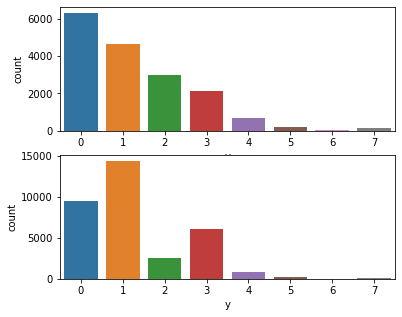

In [19]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [20]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [21]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.5631214975529046, 0.1525419800781061)

In [22]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"083_submission.csv","GroupK-Fold(pitcherID)","0.563121","0.152542","","LightGBMベクトルは除外しPitcherIDでGroupKFold"


In [23]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 31.2 ms


In [24]:
imp_df

,feature,importance,fold
0,totalPitchingCount,72227.979342,1
1,B,39467.512449,1
2,S,50875.337383,1
3,O,37164.105166,1
4,inningNo,40895.876697,1
...,...,...,...
114,batterTeam,64.638181,10
115,pitcherTeam,251.215350,10
116,b1,4014.958066,10
117,b2,2724.529819,10


In [25]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=final_estimator.feature_names__)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [26]:
coef_df

""
